# GRADIENT BOOSTING (STOCHASTIQUE) 

*Paul Liautaud & Laure Ferraris*  
  
*Avril, 2022*

# Sommaire
1. [Critères de coûts](#part1)
    - [Moindres carrés](#part1sec1)
    - [Least-Absolute Deviation](#part1sec2)
    - [Huber-M](#part1sec3)
    - [K-class multinomial negative log-likelihood](#part1sec4)
    
    
2. [Classe Gradient Boosting par arbre (Tree Boost)](#part2)
    
  
3. [Un exemple jouet](#part3)
    - [LS TreeBoost](#part3sec1)
    - [Huber TreeBoost](#part3sec2)
    - [LAD TreeBoost](#part3sec3)
    - [La force de l'aggrégation](#part3sec4)
    

4. [MNIST dataset](#part4)


5. [Diabetes dataset](#part5)

# Outils nécessaires

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from time import perf_counter
%matplotlib inline

# Critères de perte <a id="part1"></a>
Cette section est dédiée à l'introduction des différentes fonctions de coûts $L : \mathbb{R \times \mathbb{R} \to \mathbb{R}_+}$ que nous utiliserons au fil du notebook.

## 1) Moindres Carrés (LS) <a id="part1sec1"></a>
Certainement la plus classique et la plus connue, on l'utilisera dans un premier temps pour la première application de la méthode de Gradient Boosting à des données. $\forall x,y \in \mathbb R$,
$$L(x,y) = \frac{1}{2}\|x-y\|_2^2.$$

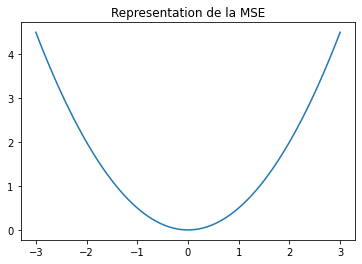

In [141]:
def mse(y,F):
    """
        Parameters:
        - y : array of length n = size_of_dataset
        - F : array of evaluations of the current Fhat estimator in the data X associated to y
    """
    return 0.5*(y-F)**2

def grad_mse(y,F):
    return((F-y))

plt.plot(np.linspace(-3,3,100),mse(np.linspace(-3,3,100),np.zeros(100)))
plt.title('Representation de la MSE');

## 2) Least-absolute deviation <a id="part1sec2"></a>

$\forall x,y \in \mathbb R, L(x,y) = |x-y|.$

Text(0.5, 1.0, 'Représentation de la LAD')

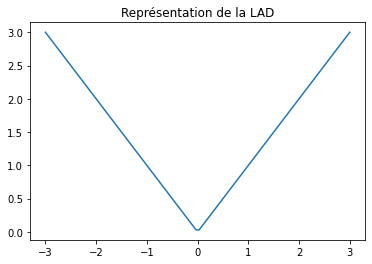

In [73]:
def lad(y,F):
    """
        Parameters:
        - y : array of length n = size_of_dataset
        - F : array of evaluations of the current Fhat estimator in the data X associated to y
    """
    return(np.abs(y-F)) #return an array

def grad_lad(y,F):
    grad = (F-y) #sign inverted because we compute the gradient in the F variable
    grad[grad > 0] = 1 
    grad[grad < 0] = - 1
    return(grad)

plt.plot(np.linspace(-3,3,100), lad(np.linspace(-3,3,100), np.zeros(100)))
plt.title('Représentation de la LAD');

## 3) Huber-M <a id="part1sec3"></a>
$\forall x,y \in \mathbb R$,
$$L(x,y) = \begin{cases} \frac{1}{2}(y-y)^2, &|x-y|\leq\delta \\
\delta\left(|x-y|-\frac{\delta}{2}\right), &|x-y)|>\delta\end{cases},$$
pour $\delta >0$ appelé paramètre de *tuning*.

Text(0.5, 1.0, 'Représentation de la Huber')

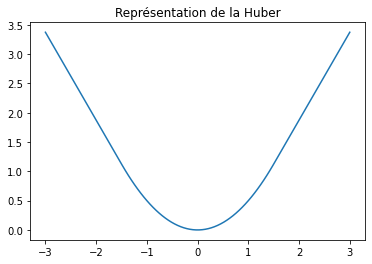

In [106]:
def huber(y,F,delta):
    h = y-F
    h[np.abs(h)<=delta] = 0.5*h[np.abs(h)<=delta]**2
    h[np.abs(h)>delta] = delta*(np.abs(h[np.abs(h)>delta])-(delta/2))
    return h

def grad_huber(y,F,delta):
    h = y-F
    h[np.abs(h)<=delta] = -h[np.abs(h)<=delta]
    g = grad_ade(y[np.abs(h)>delta],F[np.abs(h)>delta])
    h[np.abs(h)>delta] = delta*g
    return h

plt.plot(np.linspace(-3,3,100), huber(np.linspace(-3,3,100), np.zeros(100),1.5)) #[if_true] if [expression] else [if_false]
plt.title('Représentation de la Huber');

## 4) K-class multinomial negative log-likelihood <a id="part1sec4"></a>

Text(0.5, 1.0, 'Représentation de la Logit')

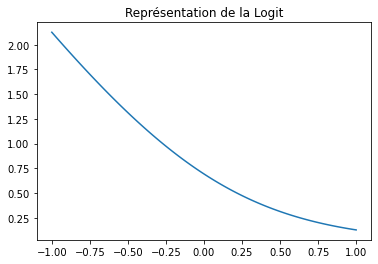

In [79]:
#Binomial negative log likelihood (2 class) 
def Bl(y,F):
    return np.log(1 + np.exp(-2*y*F))

def grad_Bl(y,F):
    return((-2*y*np.exp(-2*y*F)) / (1 + np.exp(-2*y*F)))

plt.plot(np.linspace(-1,1,100), Bl(np.linspace(-1,1,100), np.ones(100)))
plt.title('Représentation de la Logit');

# GradientBoostingTree <a id="part2"></a>

On dispose d'un jeu de données d'entraînement $\mathcal D_n := \{(\mathbf X_1,Y_1),(\mathbf X_2,Y_2),...,(\mathbf X_n,Y_n)\}$ contenant $n$ paires $(\mathbf X,Y) \in \mathcal{X} \times \mathcal{Y}$ de variables aléatoires (v.a.) où $\mathcal{X} \subset \mathbb R^d$ et $\mathcal{Y} = \{-1;1\}$ pour un problème de classification binaire ou $\mathcal{Y} = \mathbb R$ pour un problème de régression. \\
On suppose les données $\mathcal D_n$ indépendantes et identiquement distribuées (i.i.d.) et la v.a. $Y \in \mathbb R$ de carré intégrable, i.e. $\mathbb E{Y^2} < \infty$.

**But:** Dans ce cours on s'intéresse à l'estimation de la fonction $F^*: \mathcal{X} \to \mathcal{Y}$ par l'algorithme Stochastic Gradient Boosting et solution du problème

\begin{equation}
    \label{eq:argmin}
    F^* = \arg \min_{F \in \mathcal F} \mathbb{E}\left[L(Y, F(\mathbf X))\right]
\end{equation}

où $\mathcal F$ est l'espace des fonctions de $\mathcal{X} \to \mathcal{Y}$.

Le principe est de résoudre ce problème d'optimisation de façon incrémentale en procédeant en une combinaison de faible apprenant. Par itérations successives, la connaissance d'un apprenant faible - weak learner - est ajoutée au classifieur final, appelé strong classifier.

L'approche par la méthode `GradientBoostingTree` consiste à considérer des arbres CART comme apprenants de base. Pour cela, on utilisera en particulier la méthode `DecisionTreeRegressor`de `scikit-learn` comme apprenants faibles. Une classe pour une méthode boosting par arbre est implémentée ci-dessous :

In [142]:
from sklearn.tree import DecisionTreeRegressor
class GradientBoostingTree(object):
    def __init__(self, loss, learning_rate, n_estimators=10, criterion='friedman_mse', max_depth=3, max_samples=1.0, alpha=0.9):
        """
        Parameters:
        - loss: 'LS', 'LAD', 'Huber', 'LK' (LK : negativ log-likelihood for two class)
        - grad: 'directly follows from the choice of the loss'
        - learning_rate: real number between 0 and 1 (small)
        - n_estimators: number of estimators
        - criterion: 'squared_error', 'friedman_mse', 'absolute_error'
        - max_depth: maximal depth of the regressor tree
        - max_samples: ratio of samples to use for learning base regressors.
            - If max_samples=1.0: use bootstrap.
            - If max_samples<1.0: use random sampling and extract max_samples x n points
            (where n is the total number of points).
        """
        # Parameters of GradientTreeBoosting
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_samples = max_samples
        self.alpha = alpha
        
    def starter(self, X, y):
        # Make X a 2d-array
        data = np.asarray(X)
        if data.ndim == 1:
            data = data[:, np.newaxis]
            
        self.n_data = data.shape[0]  # Sample size
        self.n_sample = int(self.max_samples * self.n_data)  # Number of points for random sampling
        self.y = y
        self.data = data
        
        self.estimators_ = []
        self.regions_train_ = []
        self.regions_ = []
        self.F = []
        
        # Initialisation of F_0
    
        if self.loss == 'LS' :
            self.init = np.mean(self.y)
            #from scipy.optimize import minimize_scalar
            #self.init = minimize_scalar(lambda x : np.sum(self.loss(y,x))).x 
        
        if self.loss == 'LAD' or self.loss == 'Huber' :
            self.init = np.median(self.y)
        
        if self.loss == 'LK' :
            self.init = 0.5*np.log((1+np.mean(self.y))/(1 - np.mean(self.y)))
            
        self.F.append(self.init*np.ones(self.n_data))
        
        return self
    
    def predict(self,X):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
            
        N_pred = X.shape[0] # Number of predictions
        pred = self.init*np.ones(N_pred) # Array of preds initialized at the same value (depends on the loss)

        # Build estimators
        for t in range(self.n_estimators):
            # 1 : Sample the dataset
            if self.max_samples==1:
                idx = np.arange(self.n_data)
                #idx = np.random.randint(0, self.n, self.n)  # Bootstrap
            else:
                idx = np.random.permutation(self.n_data)[:self.n_sample]  # Random sampling
            y_sample = self.y[idx]
            data_sample = self.data[idx]
            F = self.F[-1] 
            F_sample = F[idx]
                         
            # 2 Compute the pseudo residuals y_tilde
            
            if self.loss == 'LS' :
                y_tilde = y_sample - F_sample 
                self.estimators_.append(DecisionTreeRegressor(criterion = self.criterion, max_depth=self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)
                F_sample = F_sample + self.learning_rate*self.estimators_[-1].predict(data_sample) # TRAIN (F(data) only)
                pred = pred + self.learning_rate*self.estimators_[-1].predict(X) # PREDICT
            
            elif self.loss == 'LAD' :
                # y_tilde is the sign of residuals y - F
                y_tilde = y_sample - F_sample
                y_tilde[y_tilde>0] = 1
                y_tilde[y_tilde<0] = -1
                
                # We compute gamma for each region
                # Regions
                self.estimators_.append(DecisionTreeRegressor(criterion = self.criterion, max_depth=self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)
                self.regions_train_.append(self.estimators_[-1].apply(data_sample))
                self.regions_.append(self.estimators_[-1].apply(X))
                R_train = self.regions_train_[-1] # List of x_i's region
                IDR = np.unique(R_train) # Region name
                R = self.regions_[-1]
                # Gamma
                gamma = []
                for l in IDR:
                    idl = np.argwhere(R_train==l)
                    y_l = y_sample[idl]
                    F_l = F_sample[idl]
                    gamma.append(np.median(y_l - F_l))
                    F_sample[idl] = F_sample[idl] + self.learning_rate*gamma[-1] # TRAIN
                    
                for k in range(N_pred):
                    l = R[k] #region of x_new
                    i = np.argwhere(IDR==l)[0][0]
                    pred[k] = pred[k] + self.learning_rate*gamma[i] # PREDICT
                
            elif self.loss == 'Huber' :
                # Compute delta_m
                r = y_sample - F_sample # Current residuals
                delta = np.quantile(np.abs(r), self.alpha)
                y_tilde = r
                y_tilde[r>delta] = delta
                y_tilde[r<-delta] = -delta
                
                # Regions
                self.estimators_.append(DecisionTreeRegressor(criterion = self.criterion, max_depth = self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)
                self.regions_train_.append(self.estimators_[-1].apply(data_sample))
                self.regions_.append(self.estimators_[-1].apply(X))
                R_train = self.regions_train_[-1]
                IDR = np.unique(R_train)
                R = self.regions_[-1]
                # Gamma
                gamma = []
                for l in IDR:
                    idl = np.argwhere(R_train==l)
                    r_l = r[idl]
                    r_tilde = np.median(r_l)
                    r_ = r_l - r_tilde
                    
                    r_min = np.abs(r_)
                    r_min[r_min>delta] = delta
                    r_min[r_<0] = -r_min[r_<0]
                    
                    gamma.append(r_tilde + np.sum(r_min)/len(idl))
                    F_sample[idl] = F_sample[idl] + self.learning_rate*gamma[-1] # We update F and pred separatly
                    
                for k in range(N_pred):
                    l = R[k] #region of x_new
                    i = np.argwhere(IDR==l)[0][0]
                    pred[k] = pred[k] + self.learning_rate*gamma[i] # Update of each pred   
                    
            elif self.loss == 'LK' :
                marge = 2*y_sample*F_sample
                if np.sum(1*(marge > 709)) > 0:
                    marge[marge>709] = 709
                    
                y_tilde = (2*y_sample) / (1 + np.exp(marge))
                
                # Regions
                self.estimators_.append(DecisionTreeRegressor(criterion = self.criterion, max_depth = self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)
                self.regions_train_.append(self.estimators_[-1].apply(data_sample))
                self.regions_.append(self.estimators_[-1].apply(X))
                R_train = self.regions_train_[-1]
                IDR = np.unique(R_train)
                R = self.regions_[-1]
                # Gamma
                gamma = []
                for l in IDR:
                    idl = np.argwhere(R_train==l)
                    gamma.append(np.sum(y_tilde[idl] / np.sum(np.abs(y_tilde[idl])*(2-np.abs(y_tilde[idl])))))
                    F_sample[idl] = F_sample[idl] + self.learning_rate*gamma[-1] # We update F and pred separatly
                
                for k in range(N_pred):
                    l = R[k] #region of x_new
                    i = np.argwhere(IDR==l)[0][0]
                    pred[k] = pred[k] + self.learning_rate*gamma[i] # Update of each pred  
                            
            F[idx] = F_sample    
            self.F.append(F)           
        
        if self.loss == 'LK' :
            pred = 2*(pred > 0) - 1
            
        return pred 
    
    def error(self, X, y):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if self.loss == 'LK':
            err = np.mean(1*(self.predict(X)*y < 0))
        else :
            err = np.mean((y - self.predict(X))**2)
        return err
    

# Un exemple jouet <a id="part3"></a>

Pour une première compréhension du concept de Boosting, on utilisera un jeu de données $\mathcal{D}_n$ issues d'un modèle très simple basé sur la fonction $x \to \sin(x)$. On se restreint, pour cela à un espace d'observation $\mathcal X = [0;5]$ et $\mathcal Y = \mathbb R$ de dimensions $1$. On considère le modèle de régression suivant :
$$Y = f(X) + \varepsilon,$$

où $X \sim \mathcal U_{[0;5]}, \varepsilon \sim \mathcal U_{[-0.5;0.5]}$ avec probabilité $p=\frac{1}{5}$, $\varepsilon = 0$ sinon et $f = \sin$.

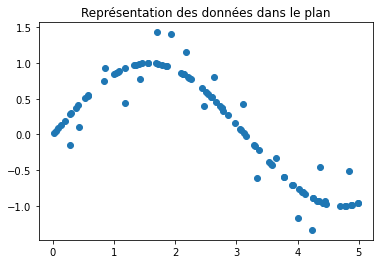

In [143]:
# Regression dataset
n = 100
X_train = np.sort(5 * np.random.rand(n))
y_train = np.sin(X_train)
y_train[::5] += 1 * (0.5 - np.random.rand(n//5))

X_test = np.arange(0, 5, step=1e-2)
y_test = np.sin(X_test)

# Make 2d-arrays
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

plt.scatter(X_train, y_train)
plt.title('Représentation des données dans le plan');

## Least-Squares Tree Boosting <a id="part3sec1"></a>

Pour ce premier cas, on consdère $L$ comme la fonction de coût moindres carrés i.e. $L(x,y) = \|x-y\|_2^2 \, \forall x,y \in \mathcal Y$. Les courbes d'erreurs en apprentissage sont alors données par les lignes de code suivantes :

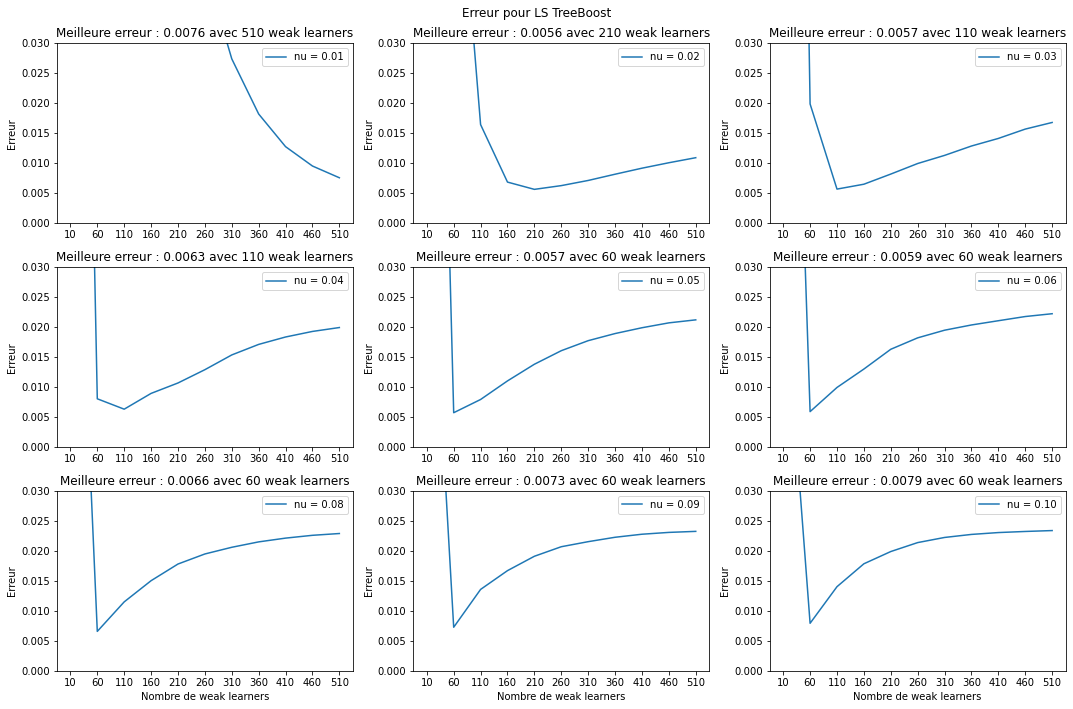

In [144]:
seed = 42
np.random.seed(seed)
Nu = np.linspace(0.005,0.1, 9)
N_est = np.arange(10,520,50)

plt.figure(figsize=(15,10))

for it,nu in enumerate(Nu):
    plt.subplot(3,3,it+1)
    err = []
    for n_est in N_est:    
        reg = GradientBoostingTree(loss='LS',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=3, max_samples=1)
        reg.starter(X_train,y_train)
        err.append(reg.error(X_test,y_test))
    i_min = np.argmin(np.array(err))
    plt.plot(N_est, err, label=f'nu = {nu:.2f}')
    if it > 5 :
        plt.xlabel('Nombre de weak learners')
    plt.xticks(N_est, [str(N) for N in N_est])
    plt.ylabel('Erreur')
    plt.ylim(0,0.03)
    plt.title(f'Meilleure erreur : {err[i_min]:.4f} avec {N_est[i_min]:d} weak learners')
    plt.legend()
plt.suptitle('Erreur pour LS TreeBoost')
plt.tight_layout();

La version stochastique du Gradient Boosting est engagée lorsque l'utilisateur fixe la proportion $f$ des données $\mathcal D_n$ à utiliser lors du sous échantillonnage aléatoire. Voici les courbes d'erreur que l'on peut espérer en fonction du pas d'apprentissage $\nu$ et de la proportion $f$ choisie.

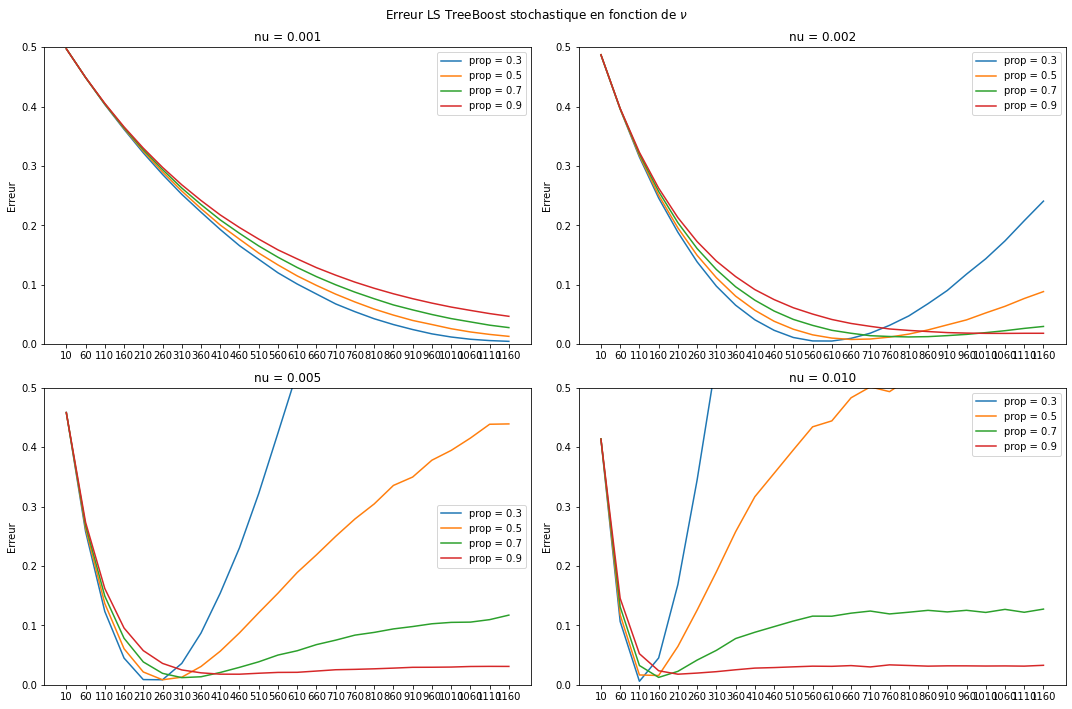

In [145]:
np.random.seed(seed)
Max_samples = [0.3,0.5,0.7,0.9]
Nu = [0.001,0.002,0.005,0.01] #np.linspace(0.001,0.1, 5)
N_est = np.arange(10,1200,50)

plt.figure(figsize=(15,10))

for m in Max_samples:
    for it,nu in enumerate(Nu):
        plt.subplot(2,2,it+1)
        err = []
        for n_est in N_est:    
            reg = GradientBoostingTree(loss='LS',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=9, max_samples=m)
            reg.starter(X_train,y_train)
            err.append(reg.error(X_test,y_test))
        i_min = np.argmin(np.array(err))
        plt.plot(N_est, err, label=f'prop = {m:.1f}')
        if it > 5 :
            plt.xlabel('Nombre de weak learners')
        plt.xticks(N_est, [str(N) for N in N_est])
        plt.ylabel('Erreur')
        plt.ylim(0,0.5)
        plt.title(f'nu = {nu:.3f}')
        plt.legend()
    plt.suptitle(r'Erreur LS TreeBoost stochastique en fonction de $\nu$')
plt.tight_layout();

De façon plus qualitative, on peut se convaincre du bon entraînement de nos modèles en traçant l'approximation faites par ces derniers.

Time :0.1378 sec
Time :0.2408 sec
Time :0.3909 sec
Time :0.4926 sec


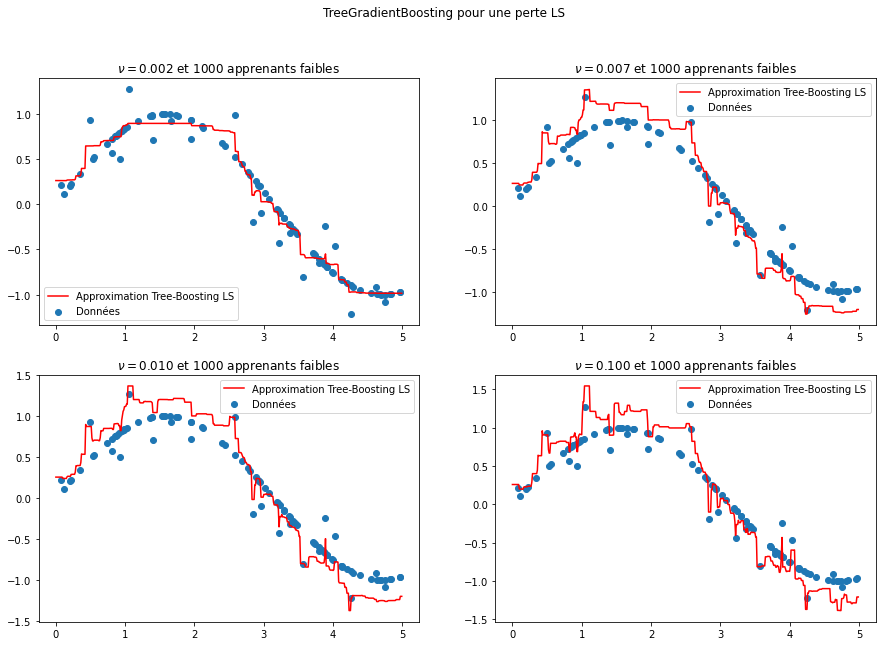

In [59]:
np.random.seed(seed)
Nu = [0.002, 0.007, 0.01, 0.1]
N_weak_learners = 1000
prop = 0.8
t0 = perf_counter()

plt.figure(figsize=(15,5*math.ceil(len(Nu)/2)))

for it,nu in enumerate(Nu):
    plt.subplot(math.ceil(len(Nu)/2),2,it+1)
    reg = GradientBoostingTree(loss='LS',learning_rate=nu, n_estimators=N_weak_learners, criterion='friedman_mse', max_depth=3, max_samples=prop)
    reg.starter(X_train, y_train)
    y_pred_mse = reg.predict(X_test)
    plt.scatter(X_train, y_train, label = 'Données')
    plt.plot(X_test, y_pred_mse, 'r',label='Approximation Tree-Boosting LS')
    plt.title(fr"$\nu ={nu:.3f}$ et ${N_weak_learners}$ apprenants faibles")
    plt.legend()
    t1 = perf_counter()
    print(f'Time :{t1-t0:.4f} sec')
plt.suptitle("TreeGradientBoosting pour une perte LS");

## Huber TreeBoosting <a id="part3sec2"></a>

Sur le même dataset $\mathcal D_n$ on obtient les résultats suivant pour $L = \operatorname{Huber}$.
Remarquons tout de suite que les courbes en apprentissage vont être assez similaires : ceci étant dû au fait que la Huber et la MSE sont très proches selon l'hyperparamètre $\delta$ choisi dans :
$$L(y,F(\mathbf x)) = \frac{1}{2}(y-F(\mathbf x))^2\mathbb{1}_{|y-F(\mathbf x)|\leq\delta} + \delta\left(|y-F(\mathbf x)|-\frac{\delta}{2}\right)\mathbb{1}_{|y-F(\mathbf x)|>\delta}.$$

En effet, le $\delta$ est défini itérativement comme un quantile empirique d'ordre $\alpha$ sur les résidus $|y-F(\mathbf x)|$: $$\delta_m \gets \operatorname{quantile}_\alpha \{|y_i-F_{m-1}(\mathbf x_i)|\}_{i=1}^n, \; 1 \leq m \leq \text{nombre d'arbres}$$

Il va permettre d'évaluer les observations potentiellement "outliers" en introduisant la notion de concentration donnée par la définition même des quantiles. Pour des données fortement concentrées autour de $[-\delta;\delta]$, on a alors qualitativement $\operatorname{Huber} \approx \operatorname{MSE}$, ce qui explique la similarité dans les courbes d'entraînement avec le `LS TreeBoosting`.
Notons que dans la classe `GradientBoostingTree` définie plus haut, l'utilisateur est libre de fixer l'hyperparamètre $\alpha$, qui, par défaut est de $0.9$ (valeur recommandée).

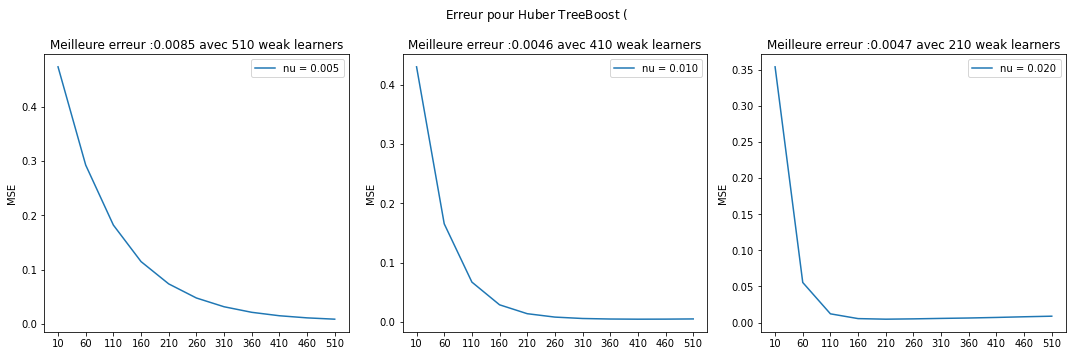

In [146]:
seed = 42
np.random.seed(seed)
Nu = [0.005,0.01,0.02] 
N_est = np.arange(10,520,50)
alpha = 0.9
plt.figure(figsize=(15,5))

for it,nu in enumerate(Nu):
    plt.subplot(1,3,it+1)
    err = []
    for n_est in N_est:    
        reg = GradientBoostingTree(loss='Huber',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=3, max_samples=1, alpha = alpha)
        reg.starter(X_train,y_train)
        err.append(reg.error(X_test,y_test))
    i_min = np.argmin(np.array(err))
    plt.plot(N_est, err, label=f'nu = {nu:.3f}')
    if it > 5 :
        plt.xlabel('Nombre de weak learners')
    plt.xticks(N_est, [str(N) for N in N_est])
    plt.ylabel('MSE')
    plt.title(f'Meilleure erreur :{err[i_min]:.4f} avec {N_est[i_min]:d} weak learners')
    plt.legend()
plt.suptitle('Erreur pour Huber TreeBoost $(\alpha = {alpha:.1f})$')
plt.tight_layout();

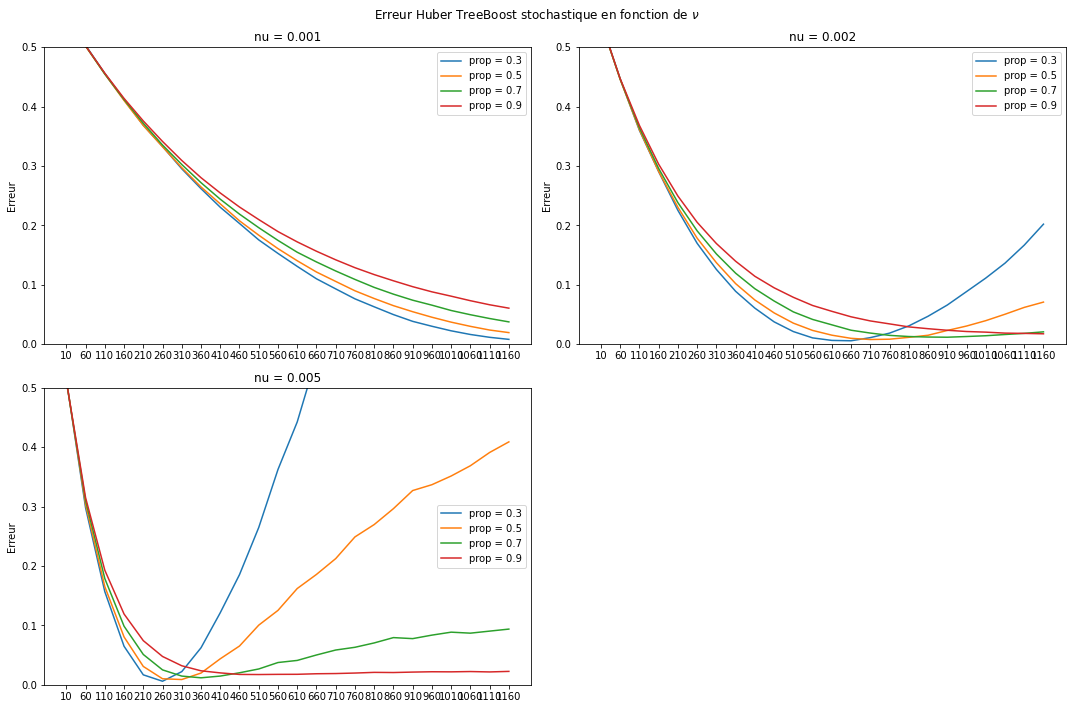

In [83]:
#stochastic version
np.random.seed(seed)
Max_samples = [0.3,0.5,0.7,0.9]
Nu = [0.001,0.002,0.005] 
N_est = np.arange(10,1200,50)
alpha = 0.8

plt.figure(figsize=(15,10))

for m in Max_samples:
    for it,nu in enumerate(Nu):
        plt.subplot(1,3,it+1)
        err = []
        for n_est in N_est:    
            reg = GradientBoostingTree(loss='Huber',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=3, max_samples=m, alpha = alpha)
            reg.starter(X_train,y_train)
            err.append(reg.error(X_test,y_test))
        i_min = np.argmin(np.array(err))
        plt.plot(N_est, err, label=f'prop = {m:.1f}')
        if it > 5 :
            plt.xlabel('Nombre de weak learners')
        plt.xticks(N_est, [str(N) for N in N_est])
        plt.ylabel('Erreur')
        plt.ylim(0,0.5)
        plt.title(f'nu = {nu:.3f}')
        plt.legend()
    plt.suptitle(r'Erreur Huber TreeBoost stochastique en fonction de $\nu (\alpha = {alpha:.1f})$)')
plt.tight_layout();

Time :2.4861 sec
Time :4.9561 sec
Time :7.4026 sec
Time :9.8499 sec


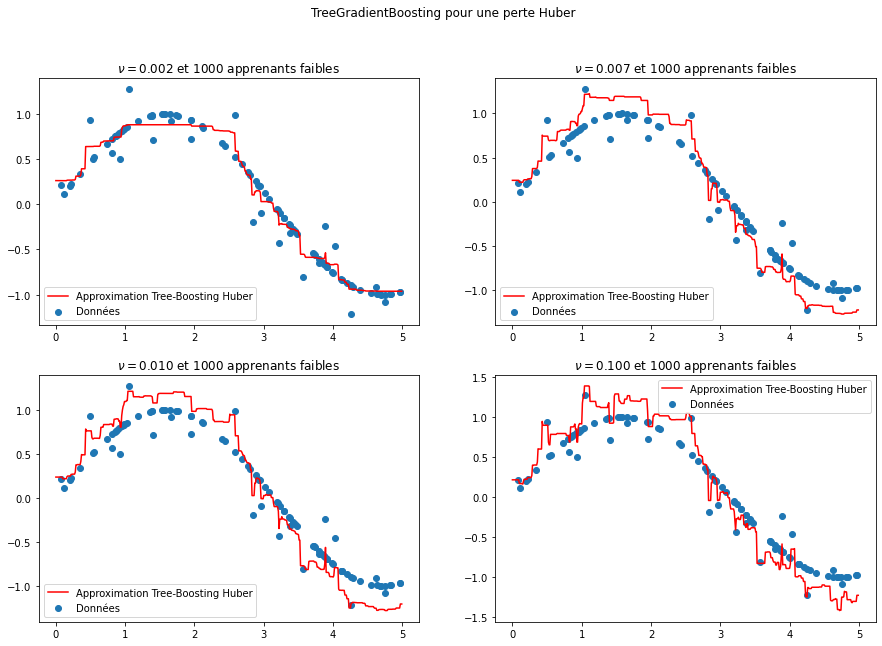

In [60]:
np.random.seed(seed)
Nu = [0.002, 0.007, 0.01, 0.1]
N_weak_learners = 1000
prop = 0.8
alpha = 0.8
t0 = perf_counter()

plt.figure(figsize=(15,5*math.ceil(len(Nu)/2)))

for it,nu in enumerate(Nu):
    plt.subplot(math.ceil(len(Nu)/2),2,it+1)
    reg = GradientBoostingTree(loss='Huber',learning_rate=nu, n_estimators=N_weak_learners, criterion='friedman_mse', max_depth=3, max_samples=prop, alpha = alpha)
    reg.starter(X_train, y_train)
    y_pred_mse = reg.predict(X_test)
    plt.scatter(X_train, y_train, label = 'Données')
    plt.plot(X_test, y_pred_mse, 'r',label='Approximation Tree-Boosting Huber')
    plt.title(fr"$\nu ={nu:.3f}$ et ${N_weak_learners}$ apprenants faibles")
    plt.legend()
    t1 = perf_counter()
    print(f'Time :{t1-t0:.4f} sec')
plt.suptitle("TreeGradientBoosting pour une perte Huber");

## Least Absolute Deviation TreeBoost <a id="part3sec3"></a>

Ici on considère la fonction valeur absolue $L(x,y) = |x-y|$.

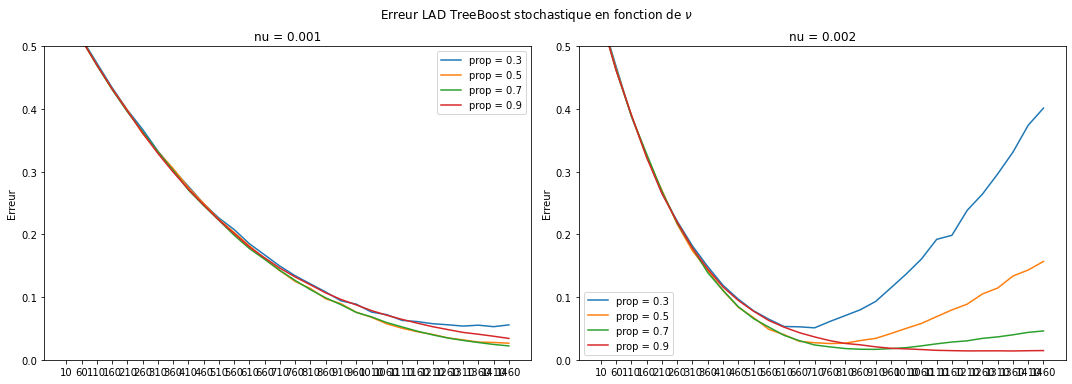

In [93]:
np.random.seed(seed)
Max_samples = [0.3,0.5,0.7,0.9]
Nu = [0.001,0.002]
N_est = np.arange(10,1500,50)

plt.figure(figsize=(15,10))

for m in Max_samples:
    for it,nu in enumerate(Nu):
        plt.subplot(2,2,it+1)
        err = []
        for n_est in N_est:    
            reg = GradientBoostingTree(loss='LAD',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=9, max_samples=m)
            reg.starter(X_train,y_train)
            err.append(reg.error(X_test,y_test))
        i_min = np.argmin(np.array(err))
        plt.plot(N_est, err, label=f'prop = {m:.1f}')
        if it > 5 :
            plt.xlabel('Nombre de weak learners')
        plt.xticks(N_est, [str(N) for N in N_est])
        plt.ylabel('Erreur')
        plt.ylim(0,0.5)
        plt.title(f'nu = {nu:.3f}')
        plt.legend()
    plt.suptitle(r'Erreur LAD TreeBoost stochastique en fonction de $\nu$')
plt.tight_layout();

En effet, en doublant $\nu$ on remarque déjà que l'on tombe dans l'overfitting. Le rôle de $\nu$ est crucial pour le bon entraînement du `GradientBoostingTree`, sur ce jeu de données en particulier. Néanmoins, pour le cas $\nu=10^{-3}$, les courbes ne semblent pas avoir atteint leur optimum (sauf pour $f=0.3$, la courbe bleue semble recrôitre). La poursuite de l'entraînement en construisant d'autres arbres pourrait sans doute conduire à une meilleure convergence en erreur de test. Comme précédemment, on peut représenter l'approximation de la fonction $F^* = \sin$ :

Time :2.3807 sec
Time :4.7213 sec
Time :7.1187 sec
Time :9.4468 sec


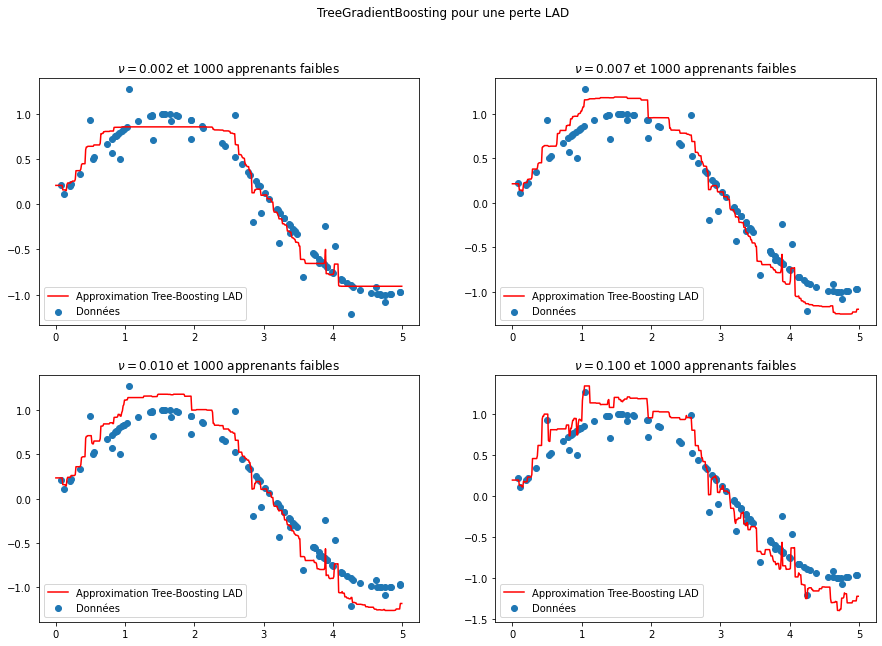

In [62]:
np.random.seed(seed)
Nu = [0.002, 0.007, 0.01, 0.1]
N_weak_learners = 1000
prop = 0.8
t0 = perf_counter()

plt.figure(figsize=(15,5*math.ceil(len(Nu)/2)))

for it,nu in enumerate(Nu):
    plt.subplot(math.ceil(len(Nu)/2),2,it+1)
    reg = GradientBoostingTree(loss='LAD',learning_rate=nu, n_estimators=N_weak_learners, criterion='friedman_mse', max_depth=3, max_samples=prop)
    reg.starter(X_train, y_train)
    y_pred_mse = reg.predict(X_test)
    plt.scatter(X_train, y_train, label = 'Données')
    plt.plot(X_test, y_pred_mse, 'r',label='Approximation Tree-Boosting LAD')
    plt.title(fr"$\nu ={nu:.3f}$ et ${N_weak_learners}$ apprenants faibles")
    plt.legend()
    t1 = perf_counter()
    print(f'Time :{t1-t0:.4f} sec')
    
plt.suptitle("TreeGradientBoosting pour une perte LAD");

## Un mélange avec les trois fonctions de perte <a id="part3sec4"></a>
Ici, en effectuant une moyenne sur les $3$ différents résultats obtenus pour chacune des pertes, on obtient une approximation encore plus précise, qui suit encore mieux la tendance de nos données $\mathcal D_n$.

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


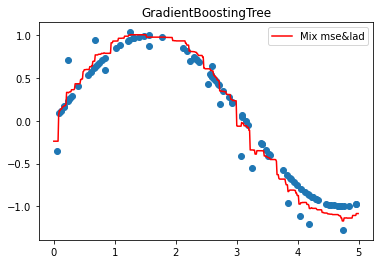

In [361]:
%time
plt.scatter(X_train, y_train)
plt.plot(X_test, (y_pred_lad+y_pred_mse+y_pred_hub)/3, 'r', label='Mix mse&lad')
plt.legend()
plt.title('GradientBoostingTree');

# Dataset MNIST <a id="part5"></a>

Ici on considère le problème de classification $1$ vs all qui consiste à entraîner un modèle pour distinguer les $0$ des autres digits.

In [94]:
# Import data
folder_path = 'mnist_data'
mnist_train = pd.read_csv(os.path.join(folder_path,'mnist_train.csv'), header=None)
mnist_test = pd.read_csv(os.path.join(folder_path,'mnist_test.csv'), header=None)

mnist_train = mnist_train.to_numpy()
mnist_test = mnist_test.to_numpy()

In [95]:
#Back to a 2 classes classification problem

y_train = 2*(mnist_train[:,0]==0)-1
y_test = 2*(mnist_test[:,0]==0)-1

#Pre processing

X_train = mnist_train[:,1:] / 255
X_test = mnist_test[:,1:] / 255

In [96]:
#Check up data

print(np.any(np.isnan(X_train)))
print(np.all(np.isfinite(X_train)))
data_train = np.nan_to_num(X_train)
print(data_train)
print(np.any(np.isnan(X_test)))
print(np.all(np.isfinite(X_test)))
data_test = np.nan_to_num(X_test)
print(data_test)

False
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
False
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [97]:
# Test
reg = GradientBoostingTree(loss='LK',learning_rate=1, n_estimators=1, criterion='friedman_mse', max_depth=3, max_samples=1)
reg.starter(X_train,y_train)
err = reg.error(X_test,y_test)
err

0.0597

In [98]:
# Test with stochastic version
reg = GradientBoostingTree(loss='LK',learning_rate=1, n_estimators=10, criterion='friedman_mse', max_depth=11, max_samples=0.1)
reg.starter(X_train,y_train)
err = reg.error(X_test,y_test)
err

0.0312

/var/folders/v9/5qdx25w101vgntz69tv1l8bh0000gn/T/ipykernel_8299/3102969460.py:174: RuntimeWarning: divide by zero encountered in true_divide
  gamma.append(np.sum(y_tilde[idl] / np.sum(np.abs(y_tilde[idl])*(2-np.abs(y_tilde[idl])))))


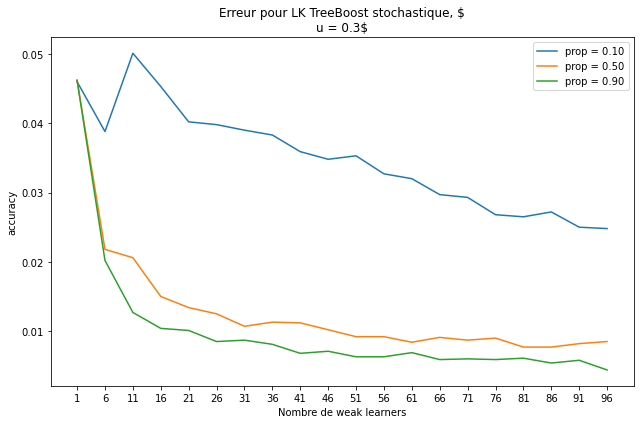

In [112]:
seed=42
np.random.seed(seed)
from time import perf_counter 
Max_samples = [0.3,0.9]
nu = 0.3
N_est = np.arange(1, 100, step=10)

plt.figure(figsize=(9,6))

for m in Max_samples:
    err = []
    for n_est in N_est:    
        reg = GradientBoostingTree(loss='LK',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=3, max_samples=m)
        reg.starter(X_train,y_train)
        err.append(reg.error(X_test,y_test))
    i_min = np.argmin(np.array(err))
    plt.plot(N_est, err, label=f'prop = {m:.2f}')
    plt.xlabel('Nombre de weak learners')
    plt.xticks(N_est, [str(N) for N in N_est])
    plt.ylabel('accuracy')
        #plt.ylim(0,0.5)
#plt.title(f'nu = {nu:.2f}')
    plt.legend()
    plt.title(f'Erreur pour LK TreeBoost stochastique, $\nu = {nu:.1f}$')
plt.tight_layout();

# Dataset diabètes `scikit` <a id="part5"></a>
Ici, on décide de tester notre méthode `GradientBoostingTree` sur des données (médicales) fournies par la bibliothèque `scikit-learn`. Pour plus d'informations au sujet du dataset considéré, on peut se référer à [Diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) et [Adaboost on diabetes dataset](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html).

In [149]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1))[:, 0]
y_test = scaler.transform(y_test.reshape(-1, 1))[:, 0]

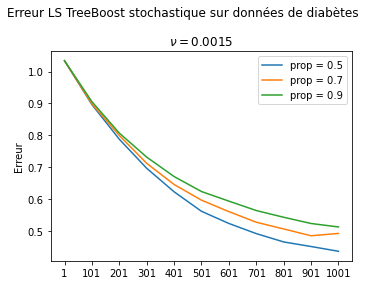

In [151]:
np.random.seed(seed)
Max_samples = [0.5,0.7,0.9]
nu = 0.0015
N_est = np.arange(1, 1002, step=100)
N_grid = np.arange(1, 1002, step=100)


plt.figure(figsize=(5,4))

for m in Max_samples:
    err = []
    for n_est in N_est:
        reg = GradientBoostingTree(loss='LS',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=5, max_samples=m)
        reg.starter(X_train,y_train)
        err.append(reg.error(X_test,y_test))
        #i_min = np.argmin(np.array(err))
    plt.plot(N_est, err, label=f'prop = {m:.1f}')
    if it > 5 :
        plt.xlabel('Nombre de weak learners')
    plt.xticks(N_grid, [str(N) for N in N_grid])
    plt.ylabel('Erreur')
    #plt.ylim(0,0.5)
    plt.title(fr'$\nu = {nu:.4f}$')
    plt.legend()
plt.suptitle(f'Erreur LS TreeBoost stochastique sur données de diabètes')
plt.tight_layout();
        

On peut notamment comparer nos résultats à d'autres méthodes d'apprentissage par *aggrégation ou bagging* (`BaggingRegressor`ou `RandomForestRegressor`) qui, pour la plupart, ne fournissent pas de résultats très performants, puisqu'ils n'atteignent pas 0.5 en précision comme il est le cas pour notre `GradientBoostingTree`.

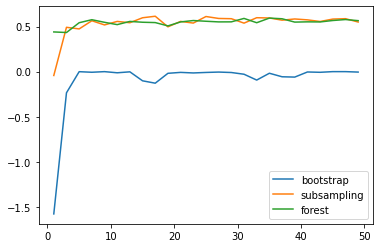

In [152]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

depth = 5
params = {"max_depth": depth}

estim = np.arange(1, 50, step=2)
for name, reg in [("bootstrap", BaggingRegressor(base_estimator=DecisionTreeRegressor(**params),
                                                 max_samples=1, bootstrap=True)),
                  ("subsampling", BaggingRegressor(base_estimator=DecisionTreeRegressor(**params),
                                                   max_samples=0.25, bootstrap=False)),
                  ("forest", RandomForestRegressor(**params))]:
    score = []
    for T in estim:
        reg.n_estimators = T
        reg.fit(X_train, y_train)
        score.append(reg.score(X_test, y_test))
    plt.plot(estim, score, label=name)
plt.legend(loc="best");